In [1]:
import requests
import os
import warnings
from tqdm import tqdm
import numpy as np
import zipfile
import rioxarray
# import xarray_leaflet
import xarray as xr
from ipyleaflet import Map, basemaps, LayersControl, WidgetControl, ImageOverlay
from rasterio.warp import Resampling
import matplotlib.pyplot as plt
import zarr
import s3fs
from dotenv import load_dotenv
import os
import ipywidgets as widgets
from ipywidgets import interact

%load_ext autoreload
%autoreload 2

In [2]:
data_path_v = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/tobfer/V1m/vo.zarr"
data_path_u = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/tobfer/U1m/uo.zarr"

In [3]:
ds_v = xr.open_zarr(data_path_v)
ds_u = xr.open_zarr(data_path_u)

In [8]:
for var_name in ds_u.data_vars:
    ds_v[var_name] = ds_u[var_name]
# ds.rio.write_nodata(np.nan, inplace=True)

In [9]:
ds = ds_v
# adffile = 'https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-coast-testing/n06_T.zarr'
# da = rioxarray.open_rasterio(adffile, masked=True) 

In [10]:
ds

<xarray.Dataset> Size: 224GB
Dimensions:        (depthv: 75, y: 3605, x: 4320, time_counter: 24, depthu: 75)
Coordinates:
  * depthv         (depthv) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    nav_lon        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 192B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 192B 1976-01-16T12:00:00 ......
  * depthu         (depthu) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x
Data variables:
    vo             (time_counter, depthv, y, x) float32 112GB dask.array<chunksize=(1, 10, 645, 4320), meta=np.ndarray>
    uo             (time_counter, depthu, y, x) float32 112GB dask.array<chunksize=(1, 10, 645, 4320), meta=np.ndarray>

In [11]:
# ds_filtered = ds.isel(y=slice(500, 700), x=slice(1000,1200))
# da = ds.zos
da = ds

In [12]:
da = da.sel(time_counter = '1976-01-16T12:00:00')

In [15]:
da

<xarray.Dataset> Size: 9GB
Dimensions:        (depthv: 75, y: 3605, x: 4320, depthu: 75)
Coordinates:
  * depthv         (depthv) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    nav_lon        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    time_centered  datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
    time_counter   datetime64[ns] 8B 1976-01-16T12:00:00
  * depthu         (depthu) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x
Data variables:
    vo             (depthv, y, x) float32 5GB dask.array<chunksize=(10, 645, 4320), meta=np.ndarray>
    uo             (depthu, y, x) float32 5GB dask.array<chunksize=(10, 645, 4320), meta=np.ndarray>

In [18]:
da = da.isel(depthu=0)
da = da.isel(depthv=0)

In [19]:
da

<xarray.Dataset> Size: 249MB
Dimensions:        (y: 3605, x: 4320)
Coordinates:
    depthv         float32 4B 0.5058
    nav_lat        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    nav_lon        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    time_centered  datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
    time_counter   datetime64[ns] 8B 1976-01-16T12:00:00
    depthu         float32 4B 0.5058
Dimensions without coordinates: y, x
Data variables:
    vo             (y, x) float32 62MB dask.array<chunksize=(645, 4320), meta=np.ndarray>
    uo             (y, x) float32 62MB dask.array<chunksize=(645, 4320), meta=np.ndarray>

In [20]:
def arrange_coordinates(da):
    if "x" not in da.dims and "y" not in da.dims:
        latitude_var_name = "lat"
        longitude_var_name = "lon"
        if "latitude" in da.dims:
            latitude_var_name = "latitude"
        if "longitude" in da.dims:
            longitude_var_name = "longitude"
        da = da.rename({latitude_var_name: "y", longitude_var_name: "x"})
    if "time" in da.dims:
        da = da.transpose("time", "y", "x")
    else:
        da = da.transpose("y", "x")
    return da

In [21]:
da = da.drop_vars('time_counter', errors='ignore')
nav_lat = ds.nav_lat.values
new_y = np.linspace(nav_lat.min(), nav_lat.max(), num=nav_lat.shape[0])
nav_lon = ds.nav_lon.values
new_x = nav_lon[1000]
da = da.assign_coords(y=new_y, x=new_x)
da = da.sortby('x')
da = da.sortby('y')
# print(da.x.values)
# import numpy as np
# da.rio.set_nodata(np.nan, inplace=True)
# da = da.fillna('-9999')
da = arrange_coordinates(da)

In [22]:
if (da.x > 180).any():
    # Adjust the longitude coordinates to the -180 to 180 range
    da = da.assign_coords(x=(da.x + 180) % 360 - 180)

    # Sort the dataset by the updated longitude coordinates
    da = da.sortby(da.x)
crs = da.rio.crs or "epsg:4326"
da.rio.write_crs(crs, inplace=True)

<xarray.Dataset> Size: 249MB
Dimensions:        (y: 3605, x: 4320)
Coordinates:
    depthv         float32 4B 0.5058
    nav_lat        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    nav_lon        (y, x) float32 62MB dask.array<chunksize=(3605, 4320), meta=np.ndarray>
    time_centered  datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
    depthu         float32 4B 0.5058
  * y              (y) float64 29kB -85.67 -85.62 -85.57 ... 89.87 89.92 89.97
  * x              (x) float32 17kB -179.9 -179.8 -179.8 ... 179.8 179.9 180.0
    spatial_ref    int64 8B 0
Data variables:
    vo             (y, x) float32 62MB dask.array<chunksize=(645, 4320), meta=np.ndarray>
    uo             (y, x) float32 62MB dask.array<chunksize=(645, 4320), meta=np.ndarray>

In [23]:
if "time_counter" in da.dims:
    if time_slice:
        time_as_str = time_slice.split("T")[0]
        if da["time_counter"].dtype == "O":
            da["time_counter"] = da["time_counter"].astype("datetime64[ns]")
        da = da.sel(
            time=numpy.array(time_as_str, dtype=numpy.datetime64), method="nearest"
        )
    else:
        da = da.isel(time_counter=0)

In [24]:
limits = [40.0, 60.0, -30.0, -20.0]
da = da.sel(y=slice(limits[0], limits[1]))
da = da.sel(x=slice(limits[2], limits[3]))    
da.attrs['scale_factor'] = 1.0
da.attrs['add_offset'] = 0.0
da = da.assign_coords(band=1)
da_filtered = da.drop_vars(['nav_lat', 'nav_lon'])

In [28]:
da_filtered1 = da_filtered.compute()
da_filtered1

<xarray.Dataset> Size: 401kB
Dimensions:        (y: 410, x: 121)
Coordinates:
    depthv         float32 4B 0.5058
    time_centered  datetime64[ns] 8B 1976-01-16T12:00:00
    depthu         float32 4B 0.5058
  * y              (y) float64 3kB 40.02 40.07 40.12 40.17 ... 59.85 59.9 59.95
  * x              (x) float32 484B -30.0 -29.92 -29.83 ... -20.17 -20.08 -20.0
    spatial_ref    int64 8B 0
    band           int64 8B 1
Data variables:
    vo             (y, x) float32 198kB 0.04744 0.05353 0.05371 ... 0.0 0.0 0.0
    uo             (y, x) float32 198kB 0.0006434 0.001273 0.002126 ... 0.0 0.0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [35]:
from ipyleaflet.velocity import Velocity

m = Map(center=[limits[0], limits[2]], zoom=4, interpolation='nearest', basemap=basemaps.CartoDB.DarkMatter)
display_options = {
    'velocityType': 'Global Wind',
    'displayPosition': 'bottomleft',
    'displayEmptyString': 'No wind data'
}
wind = Velocity(data=da_filtered1,
                zonal_speed='uo',
                meridional_speed='vo',
                latitude_dimension='y',
                longitude_dimension='x',
                velocity_scale=0.05,
                max_velocity=20,
                display_options=display_options)
m.add(wind)

Map(center=[40.0, -30.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

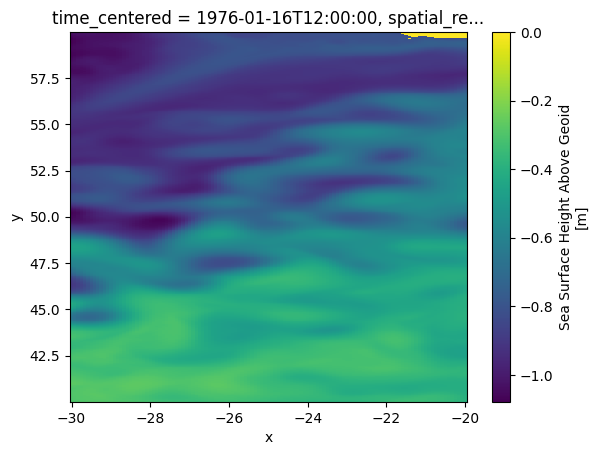

In [17]:
# da_filtered1.plot()

In [18]:
dynamic = True

from xarray_leaflet.transform import passthrough, normalize

if dynamic:
    # dynamic map
    transform0 = passthrough
    transform1 = normalize
else:
    # static map
    transform0 = normalize
    transform1 = passthrough

In [19]:
def transform2(array, *args, **kwargs):
    tile_width = kwargs['tile_width']
    tile_height = kwargs['tile_height']
    ny, nx = array.shape
    wx = nx // (tile_width // 2)
    wy = ny // (tile_height // 2)
    dim = {}
    if wx > 1:
        dim['x'] = wx
    if wy > 1:
        dim['y'] = wy
    array = array.coarsen(**dim, boundary='pad')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        array = xr.core.rolling.DataArrayCoarsen.max(array)
    return array

In [20]:
def transform3(array, *args, **kwargs):
    radius = 2
    circle = np.zeros((2*radius+1, 2*radius+1)).astype('uint8')
    y, x = np.ogrid[-radius:radius+1,-radius:radius+1]
    index = x**2 + y**2 <= radius**2
    circle[index] = 1
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        array = np.sqrt(array)
    array = scipy.ndimage.maximum_filter(array, footprint=circle)
    return array

In [21]:
# da_filtered1 = da_filtered.rio.to_raster() 
# da_filtered1.set_nodata(np.nan)


In [31]:
y = da_filtered.y.values
x = da_filtered.x.values

[40.0255135378483, -30.0] [59.958655574345556, -20.0]


In [53]:
from tempfile import NamedTemporaryFile
import base64

temp_file = NamedTemporaryFile(suffix='.tif')
da_filtered.rio.to_raster(temp_file.name)
# with open(temp_file.name, "rb") as file:
#     base64_encoded = base64.b64encode(file.read())

In [59]:
from localtileserver import get_leaflet_tile_layer, TileClient
# First, create a tile server from local raster file
client = TileClient(temp_file.name)
# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client)

m = Map(center=client.center(), zoom=client.default_zoom)
m.add(t)
m

/mnt/code/.pyenv/versions/3.10.12/envs/zarr-visualization/lib/python3.10/site-packages/rio_tiler/io/base.py:52: UserWarning: BoundingBox of the dataset is inverted (minLat > maxLat).
  warnings.warn(


Map(center=[49.992084500000004, -25.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

/mnt/code/.pyenv/versions/3.10.12/envs/zarr-visualization/lib/python3.10/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/mnt/code/.pyenv/versions/3.10.12/envs/zarr-visualization/lib/python3.10/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/mnt/code/.pyenv/versions/3.10.12/envs/zarr-visualization/lib/python3.10/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/mnt/code/.pyenv/versions/3.10.12/envs/zarr-visualization/lib/python3.10/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/mnt/code/.pyenv/versions/3.10.12/envs/zarr-visualization/lib/python3.10/site-packages/numpy/ma/core.py:467: Runtime

In [24]:

# Create a temporary file


In [23]:
# l = da_filtered1.leaflet.plot(m, colormap=plt.cm.terrain)
# # l.interact(opacity=(0., 1.))
l = da_filtered.leaflet.plot(m, colormap=plt.cm.inferno)

# l = da_filtered.leaflet.plot(m,
#                     transform0=transform0,
#                     transform1=transform1,
#                     transform2=transform2,
#                     transform3=transform3,
#                     colormap=plt.cm.inferno,
#                     dynamic=dynamic,
#                     resampling=Resampling.max)
# l.interact(opacity=(0.0,1.0,0.1))

x range: -30.00 to -20.00
y range: 40.03 to 59.96
dx: 0.08
dy: 0.05


Url()

LocalTileLayer(name='zos', options=['attribution', 'bounds', 'detect_retina', 'max_native_zoom', 'max_zoom', 'min_native_zoom', 'min_zoom', 'no_wrap', 'tile_size', 'tms', 'zoom_offset'])
transform0_args []


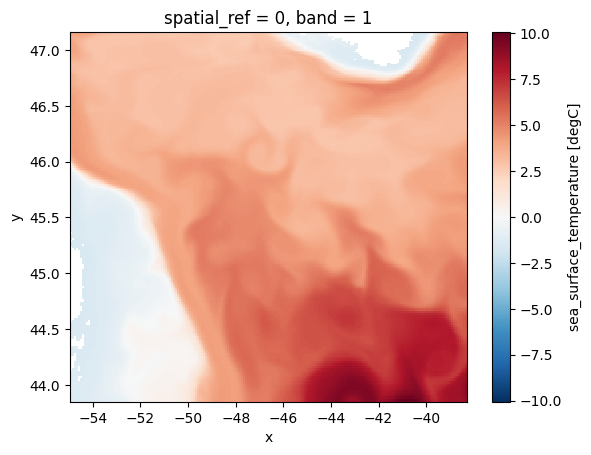

In [20]:
# layers_control = LayersControl(position='topright')
# m.add_control(layers_control)

# opacity_slider = FloatSlider(description='Opacity:', min=0, max=1, value=1)

# def set_opacity(change):
#     l.opacity = change['new']

# opacity_slider.observe(set_opacity, names='value')
# slider_control = WidgetControl(widget=opacity_slider, position='bottomleft')
# m.add_control(slider_control)

In [15]:
# da.leaflet.select()

In [12]:
# da_selected = da.leaflet.get_selection()


In [13]:
# if da_selected is not None:
    # da_selected.plot.imshow()

In [14]:
# da.leaflet.unselect()  # remove the selection buttons